In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.parser import parse
import pdb
import seaborn as sns
from tqdm import tqdm
import re
from collections import defaultdict
from Instrument import calculate_vol, preprocess

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet, ElasticNetCV, LinearRegression
from statsmodels.tsa.ar_model import AR
from arch import arch_model
import itertools


def predict_BM(df, inst_id):
    """Forecast volatility with current volatility
    
    Args:
        df: DataFrame, cleaned volatility dataframe
        inst_id: str, instrument id
    Returns:
        vols_pred: Series, predicted volatility
    """
    vols_pred = df[config.VOL_NAME].shift(1)
    vols_pred = vols_pred.fillna(vols_pred.iloc[1])
    vols_pred.name = 'benchmark'
    vols_pred.to_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '_' + vols_pred.name + '.csv'))
    print("Benchmark prediction finished.")
    return vols_pred

def predict_AR(df, inst_id, window=config.ROLLING_WINDOW, p=1):
    """ Forecast volatility with rolling window using AR(p) model
    
    Args:
        df: DataFrame, cleaned volatility dataframe
        inst_id: str, instrument id
        window: int, rolling window size
        p: int, lag of AR model
    Returns:
        vols_pred: Series, predicted volatility
    """

    fit = lambda x: AR(x).fit(maxlag=p, disp=0).predict(start=x.size, end=x.size)
#     vols_pred = df[config.VOL_NAME].expanding(min_periods=30).apply(fit)
    vols_pred = df[config.VOL_NAME].rolling(window).apply(fit)
    vols_pred.name = 'AR' + '_' + repr(window) + '_' + repr(p)
    vols_pred.to_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '_' + vols_pred.name + '.csv'))
    print(vols_pred.name + " prediction finished.")
    return vols_pred

def predict_Reg(df, inst_id, X_col=None, model_name='Lasso', p=1, params_dict=dict()):
    """ Forecast volatility with rolling window using regression model with penalty
    
    Args:
        df: DataFrame, cleaned volatility dataframe
        inst_id: str, instrument id
        X_col: list of str, names of columns in feature dataframe used for prediction 
        model_name: str, name of model, available options are 'Lasso', 'ElasticNet'
        p: int, maximum lag of features used in regression
        params_dict: dict, parameters used to initiate the regression model
    Returns:
        vols_pred: Series, predicted volatility
    """
    
    if X_col is None:
        X_col = df.columns
    if model_name == 'Lasso':
        model = Lasso(**params_dict)
    elif model_name == 'ElasticNet':
        model = ElasticNet(**params_dict)
    else:
        raise NotImplementedError("{:s} model is not implemented".format(model_name))
    def fit_predict(df, p, X_col):
        """fit and predict the volatility on the last day of df
        
        Args:
            df: DataFrame, cleaned volatility dataframe
            p: int, maximum lag of features used in regression
            X_col: list of str, names of columns in feature dataframe used for prediction 
        Returns:
            vol: float, predicted volatility of the last day of df
            coefs: np.array, coefficients of the features.
        """
        X = pd.concat([df[X_col].shift(i+1) for i in range(p)], axis=1).dropna()
        y = df[config.VOL_NAME].iloc[p:].values.ravel()
        model.fit(X, y)
        vol = model.predict(X.iloc[-1].values.reshape(1,-1))[0]
        coefs = model.coef_
        return vol, coefs
    N = len(df)
    vol_list = []
    coef_list = []
    for i in range(N):
        if (i < config.ROLLING_WINDOW):
            vol, coef = np.nan, [np.nan]*len(X_col)*p
        else:
            vol, coef = fit_predict(df.iloc[(i-config.ROLLING_WINDOW):i], p, X_col)
        vol_list.append(vol)
        coef_list.append(coef)
    vols_pred = pd.Series(vol_list, index=df.index)
    coef_columns = []
    for i in range(p):
        coef_columns += (df[X_col].columns + '_' + repr(i+1)).tolist()
    coef_df = pd.DataFrame(np.vstack(coef_list), index=df.index, columns=coef_columns)
    vols_pred.name = model_name
    vols_pred.to_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '_' + vols_pred.name + '.csv'))
    print(vols_pred.name + " prediction finished.")
    return vols_pred, coef_df

def predict_GARCH(df, inst_id, params_dict=None):
    """ Forecast next step volatility with expanding window using GARCH model
    """
    
    rolling_window = config.ROLLING_WINDOW
    if params_dict is None:
        params_dict = {'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1}
    fit = lambda x: arch_model(x, **params_dict).fit(disp='off', show_warning=False) \
                    .forecast().residual_variance.ix[x.size-1, 'h.1']
    vols_pred = df[config.VOL_NAME].rolling(rolling_window).apply(fit)
    vols_pred = vols_pred.clip(0, vols_pred.quantile(0.98))
    vols_pred.name = 'GARCH'
    vols_pred.to_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '_' + vols_pred.name + '.csv'))
    print("GARCH prediction finished.")
    return vols_pred

def dict_product(d):
    """Generate cartesian product of a dictionary of lists.
    
    Args:
        d: dict
    Returns:
        result: generator of list of dict
    """
    result = (dict(zip(d, x)) for x in itertools.product(*d.values()))
    return result

def get_mse(vols_true, vols_pred):
    """calculate root mean squared error.
    
    Args:
        vols_true: Series, true volatility
        vols_pred: Series, predicted volatility
    Returns:
        error: float, root mean squared error
    """
    vols_pred_drop = vols_pred.dropna()
    error = np.sqrt(mean_squared_error(vols_true[vols_pred_drop.index], vols_pred_drop))
    return error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# calculate volatility for the instrument id
inst_id = 'ag1604'
# calculate_vol([inst_id])

df_raw = pd.read_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '.csv'), parse_dates=['Datetime'], index_col=0)
df = pd.read_csv(os.path.join(config.OUTPUT_DATA_PATH, inst_id + '_std.csv'), index_col=0)
vols_true = df[config.VOL_NAME]
vols_true.name = 'true'

# benchmark
vols_pred_Benchmark = predict_BM(df, inst_id)

# # AR
# vols_pred_AR = predict_AR(df, inst_id)

# # # Lasso
# params_dict = {'alpha': 0.001}
# vols_pred_Lasso, coef_df = predict_Reg(df, inst_id, model_name='Lasso', p=1, params_dict=params_dict)

# # ElasticNet
# params_dict = {'alpha': 0.01, 'l1_ratio': 0.7, 'max_iter': 5000, 'warm_start': True}
# vols_pred_EN, coef_df = predict_Reg(df, inst_id, model_name='ElasticNet', p=1, params_dict=params_dict)

# Garch, takes about 15min for ag1604 to run
params_dict = {'vol': 'GARCH', 'p': =1, 'o': 0, 'q': 1}
vols_pred_GARCH = predict_GARCH(df, inst_id, params_dict)

# # parameter scan for AR
# params_universe = {'window': [30, 60, 120, 240],
#                    'p': [1, 3, 5],
#                     }
# vols_pred_AR_list = []
# mse_dict_list = []
# for i, params_dict in enumerate(dict_product(params_universe)):
#     vols_pred_AR = predict_AR(df, inst_id, **params_dict)
#     vols_pred_AR_list.append(vols_pred_AR)
#     mse_dict = params_dict
#     mse_dict['sqrt(mse)'] = get_mse(vols_true, vols_pred_AR_list[i])
#     mse_dict_list.append(mse_dict)
# mse_df = pd.DataFrame(mse_dict_list)
# mse_df = mse_df[['sqrt(mse)'] + mse_df.columns[mse_df.columns != 'sqrt(mse)'].tolist()]
# mse_df.to_csv(os.path.join(config.OUTPUT_PATH, inst_id + '_AR_Params.csv'))

# # parameter scan for ElasticNet
# params_universe = {'alpha': [0.001, 0.01, 0.1, 1, 10],
#                    'l1_ratio': [.1, .5, .7, .9 , 1],
#                    'p': [1, 2],
#                    'max_iter': [5000],
#                    'warm_start': [True],}
# vols_pred_Reg_list = []
# mse_dict_list = []
# for i, params_dict in enumerate(dict_product(params_universe)):
#     vols_pred_Reg, _ = predict_Reg(df, inst_id, model_name='ElasticNet', p=params_dict.pop('p'), params_dict=params_dict)
#     vols_pred_Reg_list.append(vols_pred_Reg)
#     mse_dict = params_dict
#     mse_dict['sqrt(mse)'] = get_mse(vols_true, vols_pred_Reg_list[i])
#     mse_dict_list.append(mse_dict)
# mse_df = pd.DataFrame(mse_dict_list)
# mse_df = mse_df[['sqrt(mse)'] + mse_df.columns[mse_df.columns != 'sqrt(mse)'].tolist()]
# mse_df.to_csv(os.path.join(config.OUTPUT_PATH, inst_id + '_ElasticNet_Params.csv'))

Benchmark prediction finished.
GARCH prediction finished.
Param_dict: 0, Runtime: 0:13:48.770595


benchmark: 0.181379
GARCH: 0.134738


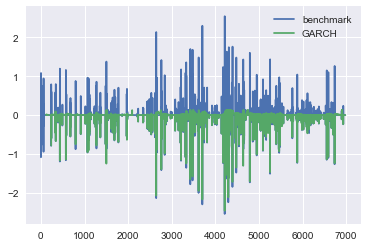

In [6]:
# compare different prediction methods
predictions = [vols_pred_Benchmark, vols_pred_AR, vols_pred_EN, vols_pred_Lasso, vols_pred_GARCH]
for vols_pred in predictions:
    mse = get_mse(vols_true, vols_pred)
    print('{:s}: {:.6f}'.format(vols_pred.name, mse))
    plt.plot(vols_pred - vols_true, label=vols_pred.name)
plt.legend()

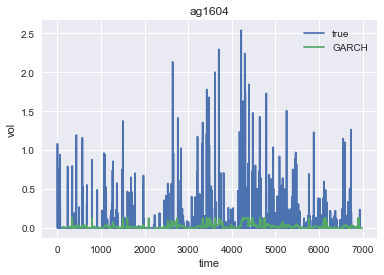

In [10]:
plt.plot(df_raw.index, vols_true)
plt.plot(df_raw.index, vols_pred_GARCH)
plt.xlabel('time')
plt.ylabel('vol')
plt.title(inst_id)
plt.legend()
# plt.savefig(os.path.join(config.OUTPUT_PATH, inst_id + 'prediction.png'), dpi=1000)